<a href="https://colab.research.google.com/github/Umadevi-2005/AICTEProject/blob/main/Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("/content/sample_data/movies_metadata1.csv", low_memory=False)







In [7]:
df = pd.read_csv("/content/sample_data/movies_metadata1.csv", low_memory=False)

In [8]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [9]:
movies = df[['title', 'genres', 'vote_average', 'popularity']].copy()
movies = movies.dropna(subset=['genres', 'vote_average', 'popularity'])

In [10]:
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []


In [11]:
movies['genre_list'] = movies['genres'].apply(parse_genres)


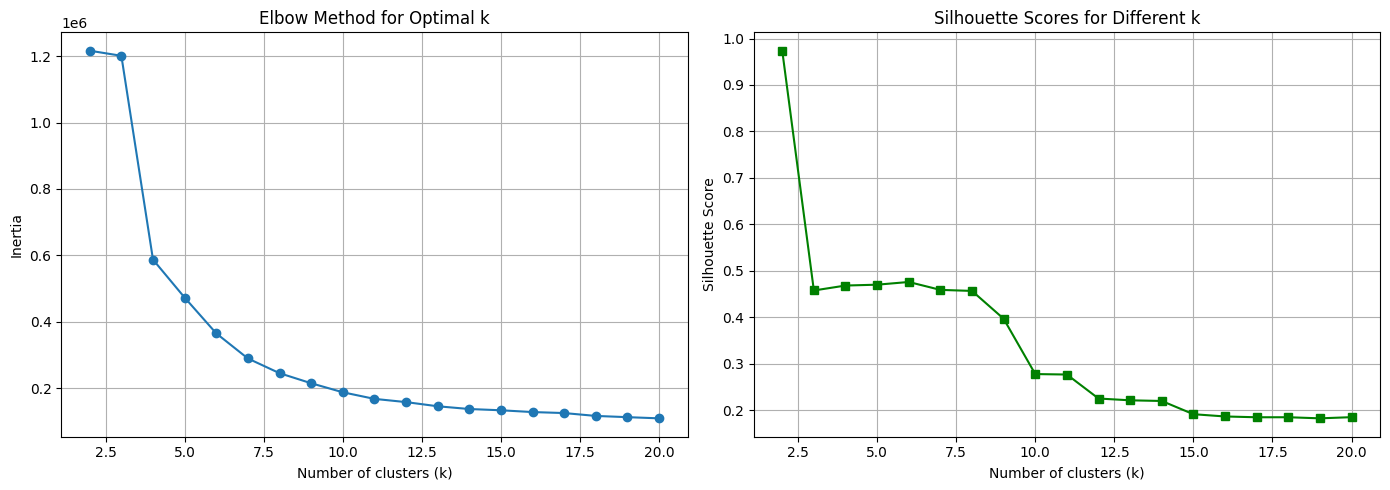

In [13]:

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])

# Combine the binary encoded genres with other numerical features
numeric_features = movies[['vote_average', 'popularity']].values
final_features = np.hstack((numeric_features, genre_encoded))
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-14-0e7392235ea7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


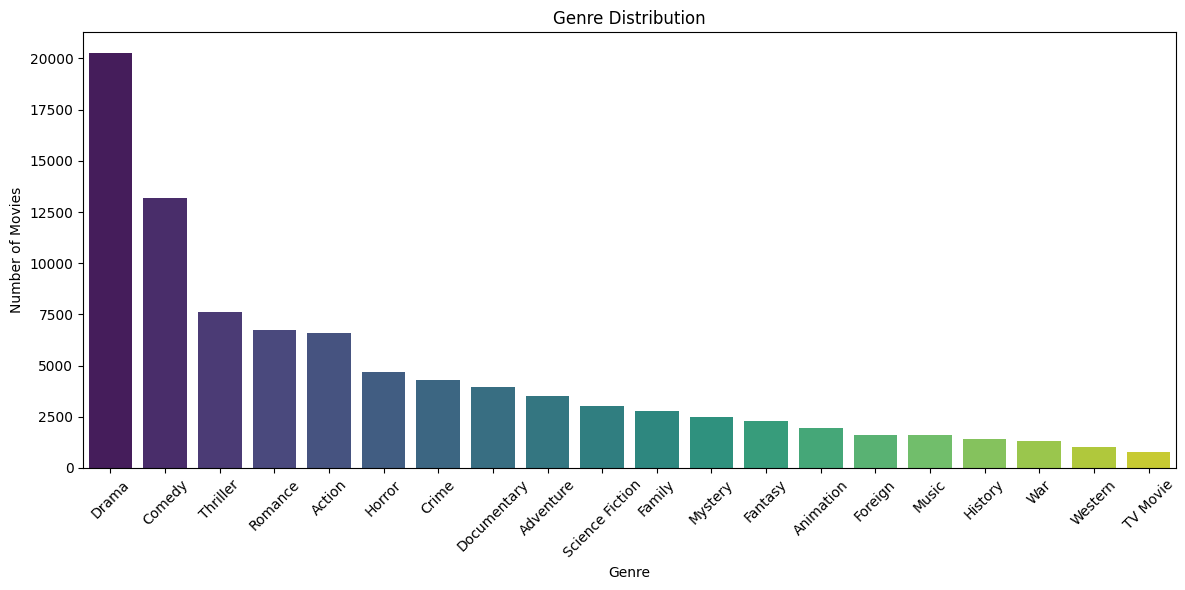

In [14]:
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [17]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)


In [18]:
# We scale vote_average and popularity to range [0, 1]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])


In [19]:
#Combine all features into one matrix
final_features = pd.concat([genre_df, scaled_df], axis=1)

<ipython-input-20-5f4a8efd25ee>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=movies['cluster'], palette='coolwarm')


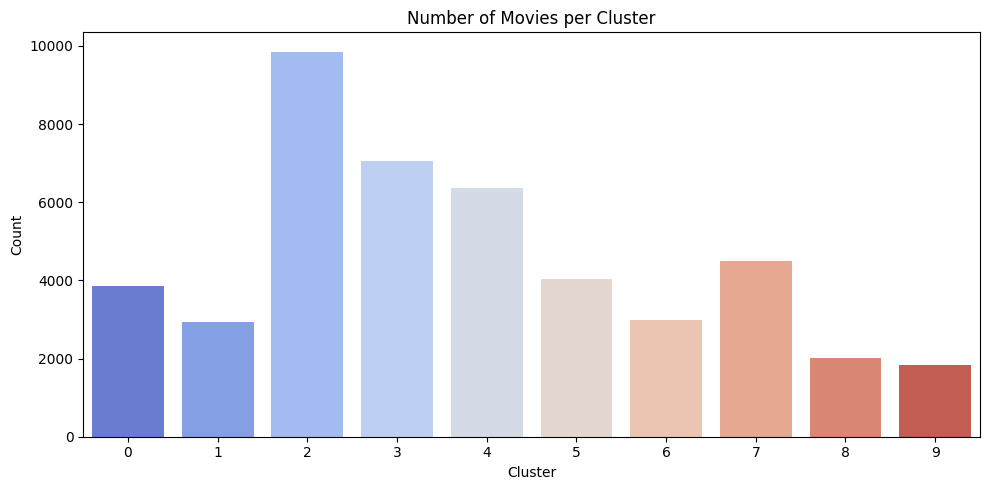

In [20]:
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

# Plot how many movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [21]:
#Define recommendation function
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies based on genre, popularity, and rating using clustering.

    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.

    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster.
    """
    # Lowercase comparison for robust matching
    target = movies[movies['title'].str.lower() == movie_title.lower()]

    if target.empty:
        return f" Movie titled '{movie_title}' not found in dataset."

    # Get the cluster of the target movie
    cluster_id = target['cluster'].values[0]

    # Get all movies from the same cluster
    similar_movies = movies[(movies['cluster'] == cluster_id) &
                            (movies['title'].str.lower() != movie_title.lower())]

    # Return top N based on vote_average and popularity
    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)


# Example usage:

print(" Recommended movies similar to 'Toy Story':")
print(recommend_movies("Heat", n=5))


 Recommended movies similar to 'Toy Story':
                                     title  vote_average popularity
24951                 Deliver Us from Evil          10.0   0.317373
39707                     American Hostage          10.0    0.11167
22346                       هیچ کجا هیچ کس          10.0   0.070407
25355                 The Great Kidnapping          10.0   0.049823
41698  Paradies 505. Ein Niederbayernkrimi          10.0   0.048331
